In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import json
import pickle

import xgboost as xgb
print("xgb.__version__:", xgb.__version__)

# local modules
import sys
sys.path.append("../src")
from preproc import process_train_data, process_test_data

xgb.__version__: 2.1.1


***
### load and preprocess data

In [2]:
# define some paths
path_raw = Path("../data/raw")
path_processed = Path("../data/processed")
path_results = Path("../data/results")

# load data
df_train = pd.read_csv(path_raw / "train.csv")
df_test = pd.read_csv(path_raw / "test.csv")

df_train

,Id,GameRulesetName,agent1,agent2,Properties,Format,Time,Discrete,Realtime,Turns,...,DoLudeme,Trigger,PlayoutsPerSecond,MovesPerSecond,EnglishRules,LudRules,num_wins_agent1,num_draws_agent1,num_losses_agent1,utility_agent1
0,0,00Y,MCTS-ProgressiveHistory-0.1-MAST-false,MCTS-ProgressiveHistory-0.6-Random200-false,1,1,1,1,0,1,...,0,1,298.07,18877.17,Goal: Connect all three edge colors with a sin...,"(game ""00'Y'"" (players 2) (equipment { (board ...",4,0,11,-0.466667
1,1,00Y,MCTS-ProgressiveHistory-0.1-MAST-false,MCTS-UCB1GRAVE-0.6-NST-true,1,1,1,1,0,1,...,0,1,298.07,18877.17,Goal: Connect all three edge colors with a sin...,"(game ""00'Y'"" (players 2) (equipment { (board ...",5,0,10,-0.333333
2,2,00Y,MCTS-ProgressiveHistory-0.1-MAST-true,MCTS-UCB1-0.1-NST-false,1,1,1,1,0,1,...,0,1,298.07,18877.17,Goal: Connect all three edge colors with a sin...,"(game ""00'Y'"" (players 2) (equipment { (board ...",7,0,8,-0.066667
3,3,00Y,MCTS-ProgressiveHistory-0.1-MAST-true,MCTS-UCB1-0.6-NST-false,1,1,1,1,0,1,...,0,1,298.07,18877.17,Goal: Connect all three edge colors with a sin...,"(game ""00'Y'"" (players 2) (equipment { (board ...",5,0,10,-0.333333
4,4,00Y,MCTS-ProgressiveHistory-0.1-MAST-true,MCTS-UCB1GRAVE-1.41421356237-NST-false,1,1,1,1,0,1,...,0,1,298.07,18877.17,Goal: Connect all three edge colors with a sin...,"(game ""00'Y'"" (players 2) (equipment { (board ...",5,0,10,-0.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
233229,233229,Zuz_Mel_7x7,MCTS-UCB1Tuned-1.41421356237-NST-false,MCTS-ProgressiveHistory-1.41421356237-Random20...,1,1,1,1,0,1,...,0,0,157.52,157174.58,7x7 board. 24 pieces per player. Pieces begin ...,"(game ""Zuz Mel (7x7)"" (players 2) (equipment {...",2,0,13,-0.733333
233230,233230,Zuz_Mel_7x7,MCTS-UCB1Tuned-1.41421356237-Random200-false,MCTS-UCB1-0.6-MAST-false,1,1,1,1,0,1,...,0,0,157.52,157174.58,7x7 board. 24 pieces per player. Pieces begin ...,"(game ""Zuz Mel (7x7)"" (players 2) (equipment {...",9,1,5,0.266667
233231,233231,Zuz_Mel_7x7,MCTS-UCB1Tuned-1.41421356237-Random200-false,MCTS-UCB1GRAVE-1.41421356237-NST-false,1,1,1,1,0,1,...,0,0,157.52,157174.58,7x7 board. 24 pieces per player. Pieces begin ...,"(game ""Zuz Mel (7x7)"" (players 2) (equipment {...",11,3,1,0.666667
233232,233232,Zuz_Mel_7x7,MCTS-UCB1Tuned-1.41421356237-Random200-false,MCTS-UCB1GRAVE-1.41421356237-NST-true,1,1,1,1,0,1,...,0,0,157.52,157174.58,7x7 board. 24 pieces per player. Pieces begin ...,"(game ""Zuz Mel (7x7)"" (players 2) (equipment {...",24,2,4,0.666667


In [3]:
# input parameters
fs_type = 'fsv24'
train_type = "small"

In [4]:
# Parameters
fs_type = "int95"


In [5]:
# Load the feature selection results
fs_mapping = {
    "full": None,
    "fsv2": '../feat_selection/select_optuna_lgbm_v2.json',
    "fsv3": '../feat_selection/select_optuna_catb.json',
    "fsv4": '../feat_selection/select_optuna_lgbm_v3.json',
    "fsv23": '../feat_selection/select_optuna_combined_v23.json',
    "fsv24": '../feat_selection/select_optuna_combined_v24.json',
    "fsv34": '../feat_selection/select_optuna_combined_v34.json',
    "int95": '../feat_selection/feat_selection_intersection_at_95.json',
    "int96": '../feat_selection/feat_selection_intersection_at_96.json',
    "int97": '../feat_selection/feat_selection_intersection_at_97.json',
    "int98": '../feat_selection/feat_selection_intersection_at_98.json',
    "int99": '../feat_selection/feat_selection_intersection_at_99.json',
    "uni80": '../feat_selection/feat_selection_union_at_80.json',
    "uni85": '../feat_selection/feat_selection_union_at_85.json',
    "uni90": '../feat_selection/feat_selection_union_at_90.json',
    "uni95": '../feat_selection/feat_selection_union_at_95.json',
}

fs_path = fs_mapping[fs_type]

if fs_path is None:
    feature_selection = dict()
else:
    with open(fs_path, 'r') as f:
        feature_selection = json.load(f)

# Extract the selected features
numerical_cols = feature_selection.get('numerical', None)
categorical_cols = feature_selection.get('categorical', None)

# text_cols = ["LudRules",]
text_cols = list()

print("Numerical features:", len(numerical_cols) if numerical_cols else 0)
print("Categorical features:", len(categorical_cols) if categorical_cols else 0)
print("Text features:", len(text_cols) if text_cols else 0)

Numerical features: 135
Categorical features: 6
Text features: 0


In [6]:
df_train, numerical_cols, categorical_cols, encoder, scaler = process_train_data(
    df_train,
    scale=False,
    numerical_cols=numerical_cols,
    categorical_cols=categorical_cols,
    include_position_features=True,
    include_text_features=False,
)

# Print the results
print("Numerical Columns:", len(numerical_cols))
print("Categorical Columns:", len(categorical_cols))

number of all nan cols:  0
number of constant cols:  0


Numerical Columns: 207
Categorical Columns: 6


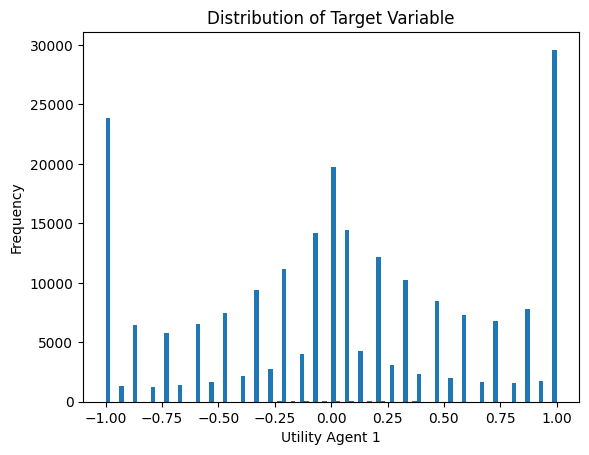

In [7]:
plt.hist(df_train['utility_agent1'], bins=100)
plt.title('Distribution of Target Variable')
plt.xlabel('Utility Agent 1')
plt.ylabel('Frequency')
plt.show()

In [8]:
split1 = pickle.load(open('../data/splits/cv1_Game.pkl', 'rb'))
split2 = pickle.load(open('../data/splits/cv2_Game.pkl', 'rb'))
split3 = pickle.load(open('../data/splits/cv3_Game.pkl', 'rb'))

# split1 = pickle.load(open('../data/splits/cv1_GameRulesetName.pkl', 'rb'))
# split2 = pickle.load(open('../data/splits/cv2_GameRulesetName.pkl', 'rb'))
# split3 = pickle.load(open('../data/splits/cv3_GameRulesetName.pkl', 'rb'))

***
### train model


In [9]:
if train_type == "small":
    LEARNING_RATE = 0.03
    NUM_BOOST_ROUND = 2500
elif train_type == "medium":
    LEARNING_RATE = 0.01
    NUM_BOOST_ROUND = 5000
elif train_type == "large":
    LEARNING_RATE = 0.005
    NUM_BOOST_ROUND = 10_000
elif train_type == "xlarge":
    LEARNING_RATE = 0.001
    NUM_BOOST_ROUND = 20_000


print(LEARNING_RATE, NUM_BOOST_ROUND)

0.03 2500


In [10]:
def train_models(
        df_train,
        target,
        numerical_cols,
        categorical_cols,
        split_list=None
    ):
    # Define the parameters
    params = {
        'objective': "reg:squarederror",
        'eval_metric': 'rmse',
        'max_depth': 8,
        'max_bin': 128,
        'learning_rate': LEARNING_RATE,
        'alpha': 0.1,
        'colsample_bytree': 0.5,
        'subsample': 0.8,
        'min_child_weight': 10,
        'seed': 2112,
        'verbosity': 0,
    }

    trained_models = []
    oof = pd.DataFrame(
        index=df_train.index,
        columns=[f'{target}_true', f'{target}_pred', 'fold']
    )
    oof_scores = []
    feat_importance_dfs = []

    # Perform cross-validation
    for fold, (train_index, val_index) in enumerate(split_list, 1):
        print(f"Fold {fold}")
        
        # Split the data
        X_train, X_val = df_train.iloc[train_index], df_train.iloc[val_index]
        y_train, y_val = X_train[target], X_val[target]

        feature_types = [
            "c" if col in categorical_cols else "q" 
            for col in numerical_cols + categorical_cols
        ]
        
        # Convert to DMatrix format
        train_data = xgb.DMatrix(
            data=X_train[numerical_cols + categorical_cols],
            label=y_train,
            feature_types=feature_types,
            enable_categorical=True,
            feature_names=numerical_cols + categorical_cols
        )
        val_data = xgb.DMatrix(
            data=X_val[numerical_cols + categorical_cols],
            label=y_val,
            feature_types=feature_types,
            enable_categorical=True,
            feature_names=numerical_cols + categorical_cols
        )

        # Train the model
        model = xgb.train(
            params,
            train_data,
            num_boost_round=NUM_BOOST_ROUND,
            evals=[(val_data, 'val')],
            verbose_eval=100,
        )
        
        # Get feature importance
        importance_dict = model.get_score(importance_type='gain')
        feat_importance = pd.DataFrame(
            {'feature': list(importance_dict.keys()),
             f'importance_f{fold}': list(importance_dict.values())}
        )
        feat_importance_dfs.append(feat_importance)
        
        # Save the trained model to the list
        trained_models.append(model)

        # predict on validation set
        y_pred = model.predict(val_data)

        # Save out-of-fold predictions
        oof.loc[val_index, f'{target}_true'] = y_val
        oof.loc[val_index, f'{target}_pred'] = y_pred
        oof.loc[val_index, 'fold'] = fold

        # Compute RMSE
        y_pred = np.clip(y_pred, -1, 1)
        rmse = np.sqrt(np.mean((y_pred - y_val) ** 2))
        print(f"Fold {fold} - RMSE: {rmse}")

        # Save RMSE to the list
        oof_scores.append(rmse)

    # Combine feature importance dataframes
    importance_df = feat_importance_dfs[0]
    for df in feat_importance_dfs[1:]:
        importance_df = importance_df.merge(df, on='feature')
    
    # Calculate mean importance across folds
    importance_cols = [col for col in importance_df.columns if col.startswith('importance_f')]
    importance_df['importance_mean'] = importance_df[importance_cols].mean(axis=1)
    importance_df = importance_df.sort_values('importance_mean', ascending=False, ignore_index=True)
    importance_df['importance_relative'] = (
        importance_df['importance_mean'] / 
        importance_df['importance_mean'].sum()
    )

    # Print the list of oof scores and average oof score
    print("List of oof scores:", oof_scores)
    print("Average oof score:", np.mean(oof_scores))

    return trained_models, oof, oof_scores, importance_df

In [11]:
# call the function
trained_models1, oof1, oof_scores1, importance_df1 = train_models(
    df_train,
    'utility_agent1',
    numerical_cols,
    categorical_cols,
    split_list=split1,
)
# save oof predictions
oof1.to_parquet(path_results / f'oof_xgboost_{fs_type}_cv1.parquet', index=False)

Fold 1


[0]	val-rmse:0.55400


[100]	val-rmse:0.46768


[200]	val-rmse:0.44922


[300]	val-rmse:0.43921


[400]	val-rmse:0.43417


[500]	val-rmse:0.43150


[600]	val-rmse:0.42941


[700]	val-rmse:0.42817


[800]	val-rmse:0.42730


[900]	val-rmse:0.42698


[1000]	val-rmse:0.42662


[1100]	val-rmse:0.42637


[1200]	val-rmse:0.42633


[1300]	val-rmse:0.42605


[1400]	val-rmse:0.42604


[1500]	val-rmse:0.42598


[1600]	val-rmse:0.42578


[1700]	val-rmse:0.42578


[1800]	val-rmse:0.42575


[1900]	val-rmse:0.42573


[2000]	val-rmse:0.42574


[2100]	val-rmse:0.42587


[2200]	val-rmse:0.42589


[2300]	val-rmse:0.42586


[2400]	val-rmse:0.42585


[2499]	val-rmse:0.42593


Fold 1 - RMSE: 0.425589134749439
Fold 2


[0]	val-rmse:0.58842


[100]	val-rmse:0.48160


[200]	val-rmse:0.46255


[300]	val-rmse:0.45486


[400]	val-rmse:0.45094


[500]	val-rmse:0.44871


[600]	val-rmse:0.44719


[700]	val-rmse:0.44614


[800]	val-rmse:0.44559


[900]	val-rmse:0.44507


[1000]	val-rmse:0.44460


[1100]	val-rmse:0.44444


[1200]	val-rmse:0.44429


[1300]	val-rmse:0.44402


[1400]	val-rmse:0.44384


[1500]	val-rmse:0.44384


[1600]	val-rmse:0.44359


[1700]	val-rmse:0.44343


[1800]	val-rmse:0.44348


[1900]	val-rmse:0.44336


[2000]	val-rmse:0.44353


[2100]	val-rmse:0.44347


[2200]	val-rmse:0.44357


[2300]	val-rmse:0.44344


[2400]	val-rmse:0.44350


[2499]	val-rmse:0.44345


Fold 2 - RMSE: 0.44311812023886277
Fold 3


[0]	val-rmse:0.60484


[100]	val-rmse:0.48487


[200]	val-rmse:0.46267


[300]	val-rmse:0.45385


[400]	val-rmse:0.44974


[500]	val-rmse:0.44793


[600]	val-rmse:0.44624


[700]	val-rmse:0.44525


[800]	val-rmse:0.44445


[900]	val-rmse:0.44420


[1000]	val-rmse:0.44381


[1100]	val-rmse:0.44351


[1200]	val-rmse:0.44321


[1300]	val-rmse:0.44316


[1400]	val-rmse:0.44319


[1500]	val-rmse:0.44304


[1600]	val-rmse:0.44320


[1700]	val-rmse:0.44305


[1800]	val-rmse:0.44304


[1900]	val-rmse:0.44305


[2000]	val-rmse:0.44304


[2100]	val-rmse:0.44309


[2200]	val-rmse:0.44303


[2300]	val-rmse:0.44307


[2400]	val-rmse:0.44306


[2499]	val-rmse:0.44301


Fold 3 - RMSE: 0.4425121736492032
Fold 4


[0]	val-rmse:0.59662


[100]	val-rmse:0.48270


[200]	val-rmse:0.46213


[300]	val-rmse:0.45231


[400]	val-rmse:0.44726


[500]	val-rmse:0.44481


[600]	val-rmse:0.44291


[700]	val-rmse:0.44208


[800]	val-rmse:0.44116


[900]	val-rmse:0.44034


[1000]	val-rmse:0.43968


[1100]	val-rmse:0.43912


[1200]	val-rmse:0.43886


[1300]	val-rmse:0.43868


[1400]	val-rmse:0.43857


[1500]	val-rmse:0.43835


[1600]	val-rmse:0.43813


[1700]	val-rmse:0.43804


[1800]	val-rmse:0.43792


[1900]	val-rmse:0.43777


[2000]	val-rmse:0.43777


[2100]	val-rmse:0.43762


[2200]	val-rmse:0.43755


[2300]	val-rmse:0.43756


[2400]	val-rmse:0.43757


[2499]	val-rmse:0.43761


Fold 4 - RMSE: 0.437196391967517
Fold 5


[0]	val-rmse:0.54824


[100]	val-rmse:0.45629


[200]	val-rmse:0.43355


[300]	val-rmse:0.42234


[400]	val-rmse:0.41651


[500]	val-rmse:0.41373


[600]	val-rmse:0.41200


[700]	val-rmse:0.41094


[800]	val-rmse:0.40994


[900]	val-rmse:0.40963


[1000]	val-rmse:0.40897


[1100]	val-rmse:0.40847


[1200]	val-rmse:0.40830


[1300]	val-rmse:0.40818


[1400]	val-rmse:0.40815


[1500]	val-rmse:0.40812


[1600]	val-rmse:0.40811


[1700]	val-rmse:0.40814


[1800]	val-rmse:0.40804


[1900]	val-rmse:0.40797


[2000]	val-rmse:0.40806


[2100]	val-rmse:0.40802


[2200]	val-rmse:0.40800


[2300]	val-rmse:0.40791


[2400]	val-rmse:0.40785


[2499]	val-rmse:0.40787


Fold 5 - RMSE: 0.40762054710467854
List of oof scores: [0.425589134749439, 0.44311812023886277, 0.4425121736492032, 0.437196391967517, 0.40762054710467854]
Average oof score: 0.43120727354194005


In [12]:
# call the function
trained_models2, oof2, oof_scores2, importance_df2 = train_models(
    df_train,
    'utility_agent1',
    numerical_cols,
    categorical_cols,
    split_list=split2,
)
# save oof predictions
oof2.to_parquet(path_results / f'oof_xgboost_{fs_type}_cv2.parquet', index=False)

Fold 1


[0]	val-rmse:0.53559


[100]	val-rmse:0.45165


[200]	val-rmse:0.43385


[300]	val-rmse:0.42598


[400]	val-rmse:0.42108


[500]	val-rmse:0.41886


[600]	val-rmse:0.41693


[700]	val-rmse:0.41522


[800]	val-rmse:0.41462


[900]	val-rmse:0.41388


[1000]	val-rmse:0.41337


[1100]	val-rmse:0.41310


[1200]	val-rmse:0.41276


[1300]	val-rmse:0.41254


[1400]	val-rmse:0.41233


[1500]	val-rmse:0.41200


[1600]	val-rmse:0.41196


[1700]	val-rmse:0.41188


[1800]	val-rmse:0.41182


[1900]	val-rmse:0.41169


[2000]	val-rmse:0.41166


[2100]	val-rmse:0.41167


[2200]	val-rmse:0.41167


[2300]	val-rmse:0.41166


[2400]	val-rmse:0.41169


[2499]	val-rmse:0.41165


Fold 1 - RMSE: 0.4113585423175291
Fold 2


[0]	val-rmse:0.54590


[100]	val-rmse:0.43777


[200]	val-rmse:0.41795


[300]	val-rmse:0.41090


[400]	val-rmse:0.40801


[500]	val-rmse:0.40636


[600]	val-rmse:0.40515


[700]	val-rmse:0.40447


[800]	val-rmse:0.40394


[900]	val-rmse:0.40389


[1000]	val-rmse:0.40373


[1100]	val-rmse:0.40357


[1200]	val-rmse:0.40350


[1300]	val-rmse:0.40353


[1400]	val-rmse:0.40358


[1500]	val-rmse:0.40352


[1600]	val-rmse:0.40361


[1700]	val-rmse:0.40365


[1800]	val-rmse:0.40363


[1900]	val-rmse:0.40365


[2000]	val-rmse:0.40368


[2100]	val-rmse:0.40361


[2200]	val-rmse:0.40371


[2300]	val-rmse:0.40385


[2400]	val-rmse:0.40399


[2499]	val-rmse:0.40403


Fold 2 - RMSE: 0.4037073664337882
Fold 3


[0]	val-rmse:0.61228


[100]	val-rmse:0.49090


[200]	val-rmse:0.46474


[300]	val-rmse:0.45274


[400]	val-rmse:0.44734


[500]	val-rmse:0.44428


[600]	val-rmse:0.44200


[700]	val-rmse:0.44005


[800]	val-rmse:0.43907


[900]	val-rmse:0.43804


[1000]	val-rmse:0.43738


[1100]	val-rmse:0.43657


[1200]	val-rmse:0.43627


[1300]	val-rmse:0.43586


[1400]	val-rmse:0.43567


[1500]	val-rmse:0.43537


[1600]	val-rmse:0.43518


[1700]	val-rmse:0.43502


[1800]	val-rmse:0.43503


[1900]	val-rmse:0.43490


[2000]	val-rmse:0.43475


[2100]	val-rmse:0.43472


[2200]	val-rmse:0.43474


[2300]	val-rmse:0.43462


[2400]	val-rmse:0.43466


[2499]	val-rmse:0.43457


Fold 3 - RMSE: 0.43423911044646313
Fold 4


[0]	val-rmse:0.60560


[100]	val-rmse:0.49395


[200]	val-rmse:0.46884


[300]	val-rmse:0.45927


[400]	val-rmse:0.45513


[500]	val-rmse:0.45258


[600]	val-rmse:0.45084


[700]	val-rmse:0.44964


[800]	val-rmse:0.44873


[900]	val-rmse:0.44831


[1000]	val-rmse:0.44779


[1100]	val-rmse:0.44726


[1200]	val-rmse:0.44709


[1300]	val-rmse:0.44679


[1400]	val-rmse:0.44664


[1500]	val-rmse:0.44662


[1600]	val-rmse:0.44644


[1700]	val-rmse:0.44652


[1800]	val-rmse:0.44645


[1900]	val-rmse:0.44650


[2000]	val-rmse:0.44642


[2100]	val-rmse:0.44632


[2200]	val-rmse:0.44629


[2300]	val-rmse:0.44637


[2400]	val-rmse:0.44643


[2499]	val-rmse:0.44650


Fold 4 - RMSE: 0.4461593147587979
Fold 5


[0]	val-rmse:0.59048


[100]	val-rmse:0.48303


[200]	val-rmse:0.45903


[300]	val-rmse:0.44716


[400]	val-rmse:0.44174


[500]	val-rmse:0.43853


[600]	val-rmse:0.43669


[700]	val-rmse:0.43525


[800]	val-rmse:0.43429


[900]	val-rmse:0.43362


[1000]	val-rmse:0.43305


[1100]	val-rmse:0.43259


[1200]	val-rmse:0.43240


[1300]	val-rmse:0.43219


[1400]	val-rmse:0.43210


[1500]	val-rmse:0.43207


[1600]	val-rmse:0.43213


[1700]	val-rmse:0.43197


[1800]	val-rmse:0.43191


[1900]	val-rmse:0.43188


[2000]	val-rmse:0.43175


[2100]	val-rmse:0.43156


[2200]	val-rmse:0.43161


[2300]	val-rmse:0.43163


[2400]	val-rmse:0.43162


[2499]	val-rmse:0.43163


Fold 5 - RMSE: 0.43107493444135075
List of oof scores: [0.4113585423175291, 0.4037073664337882, 0.43423911044646313, 0.4461593147587979, 0.43107493444135075]
Average oof score: 0.4253078536795858


In [13]:
# call the function
trained_models3, oof3, oof_scores3, importance_df3 = train_models(
    df_train,
    'utility_agent1',
    numerical_cols,
    categorical_cols,
    split_list=split3,
)
# save oof predictions
oof3.to_parquet(path_results / f'oof_xgboost_{fs_type}_cv3.parquet', index=False)

Fold 1


[0]	val-rmse:0.57616


[100]	val-rmse:0.47908


[200]	val-rmse:0.45689


[300]	val-rmse:0.44846


[400]	val-rmse:0.44405


[500]	val-rmse:0.44165


[600]	val-rmse:0.44029


[700]	val-rmse:0.43972


[800]	val-rmse:0.43893


[900]	val-rmse:0.43855


[1000]	val-rmse:0.43816


[1100]	val-rmse:0.43794


[1200]	val-rmse:0.43786


[1300]	val-rmse:0.43766


[1400]	val-rmse:0.43768


[1500]	val-rmse:0.43759


[1600]	val-rmse:0.43743


[1700]	val-rmse:0.43748


[1800]	val-rmse:0.43752


[1900]	val-rmse:0.43756


[2000]	val-rmse:0.43762


[2100]	val-rmse:0.43761


[2200]	val-rmse:0.43769


[2300]	val-rmse:0.43768


[2400]	val-rmse:0.43783


[2499]	val-rmse:0.43783


Fold 1 - RMSE: 0.4374340109222109
Fold 2


[0]	val-rmse:0.57515


[100]	val-rmse:0.46977


[200]	val-rmse:0.44310


[300]	val-rmse:0.43099


[400]	val-rmse:0.42508


[500]	val-rmse:0.42186


[600]	val-rmse:0.41967


[700]	val-rmse:0.41819


[800]	val-rmse:0.41717


[900]	val-rmse:0.41636


[1000]	val-rmse:0.41601


[1100]	val-rmse:0.41550


[1200]	val-rmse:0.41517


[1300]	val-rmse:0.41500


[1400]	val-rmse:0.41475


[1500]	val-rmse:0.41454


[1600]	val-rmse:0.41437


[1700]	val-rmse:0.41429


[1800]	val-rmse:0.41423


[1900]	val-rmse:0.41415


[2000]	val-rmse:0.41404


[2100]	val-rmse:0.41402


[2200]	val-rmse:0.41410


[2300]	val-rmse:0.41418


[2400]	val-rmse:0.41416


[2499]	val-rmse:0.41411


Fold 2 - RMSE: 0.41382927483815457
Fold 3


[0]	val-rmse:0.57921


[100]	val-rmse:0.47844


[200]	val-rmse:0.45885


[300]	val-rmse:0.45066


[400]	val-rmse:0.44665


[500]	val-rmse:0.44451


[600]	val-rmse:0.44312


[700]	val-rmse:0.44195


[800]	val-rmse:0.44116


[900]	val-rmse:0.44048


[1000]	val-rmse:0.44000


[1100]	val-rmse:0.43945


[1200]	val-rmse:0.43924


[1300]	val-rmse:0.43904


[1400]	val-rmse:0.43912


[1500]	val-rmse:0.43895


[1600]	val-rmse:0.43888


[1700]	val-rmse:0.43882


[1800]	val-rmse:0.43874


[1900]	val-rmse:0.43873


[2000]	val-rmse:0.43874


[2100]	val-rmse:0.43882


[2200]	val-rmse:0.43884


[2300]	val-rmse:0.43885


[2400]	val-rmse:0.43887


[2499]	val-rmse:0.43885


Fold 3 - RMSE: 0.43856402745369266
Fold 4


[0]	val-rmse:0.57487


[100]	val-rmse:0.46595


[200]	val-rmse:0.44465


[300]	val-rmse:0.43489


[400]	val-rmse:0.43040


[500]	val-rmse:0.42828


[600]	val-rmse:0.42649


[700]	val-rmse:0.42529


[800]	val-rmse:0.42453


[900]	val-rmse:0.42402


[1000]	val-rmse:0.42370


[1100]	val-rmse:0.42318


[1200]	val-rmse:0.42296


[1300]	val-rmse:0.42301


[1400]	val-rmse:0.42275


[1500]	val-rmse:0.42264


[1600]	val-rmse:0.42258


[1700]	val-rmse:0.42233


[1800]	val-rmse:0.42240


[1900]	val-rmse:0.42239


[2000]	val-rmse:0.42242


[2100]	val-rmse:0.42229


[2200]	val-rmse:0.42231


[2300]	val-rmse:0.42229


[2400]	val-rmse:0.42224


[2499]	val-rmse:0.42212


Fold 4 - RMSE: 0.42180978924718815
Fold 5


[0]	val-rmse:0.58626


[100]	val-rmse:0.48324


[200]	val-rmse:0.46219


[300]	val-rmse:0.45135


[400]	val-rmse:0.44612


[500]	val-rmse:0.44270


[600]	val-rmse:0.44086


[700]	val-rmse:0.43888


[800]	val-rmse:0.43795


[900]	val-rmse:0.43714


[1000]	val-rmse:0.43660


[1100]	val-rmse:0.43611


[1200]	val-rmse:0.43585


[1300]	val-rmse:0.43551


[1400]	val-rmse:0.43537


[1500]	val-rmse:0.43528


[1600]	val-rmse:0.43529


[1700]	val-rmse:0.43521


[1800]	val-rmse:0.43508


[1900]	val-rmse:0.43494


[2000]	val-rmse:0.43486


[2100]	val-rmse:0.43492


[2200]	val-rmse:0.43495


[2300]	val-rmse:0.43492


[2400]	val-rmse:0.43496


[2499]	val-rmse:0.43501


Fold 5 - RMSE: 0.4345902528384688
List of oof scores: [0.4374340109222109, 0.41382927483815457, 0.43856402745369266, 0.42180978924718815, 0.4345902528384688]
Average oof score: 0.42924547105994304


In [14]:
# Print summary of OOF scores for each CV fold
print("CV1 OOF Scores:")
for score in oof_scores1:
    print(f"Score: {score:.4f}")
print(f"Average CV1 Score: {sum(oof_scores1)/len(oof_scores1):.4f}")
    
print("\nCV2 OOF Scores:")  
for score in oof_scores2:
    print(f"Score: {score:.4f}")
print(f"Average CV2 Score: {sum(oof_scores2)/len(oof_scores2):.4f}")
    
print("\nCV3 OOF Scores:")
for score in oof_scores3:
    print(f"Score: {score:.4f}")
print(f"Average CV3 Score: {sum(oof_scores3)/len(oof_scores3):.4f}")

CV1 OOF Scores:
Score: 0.4256
Score: 0.4431
Score: 0.4425
Score: 0.4372
Score: 0.4076
Average CV1 Score: 0.4312

CV2 OOF Scores:
Score: 0.4114
Score: 0.4037
Score: 0.4342
Score: 0.4462
Score: 0.4311
Average CV2 Score: 0.4253

CV3 OOF Scores:
Score: 0.4374
Score: 0.4138
Score: 0.4386
Score: 0.4218
Score: 0.4346
Average CV3 Score: 0.4292


In [15]:
trained_models = [*trained_models1, *trained_models2, *trained_models3]
# trained_models = trained_models1

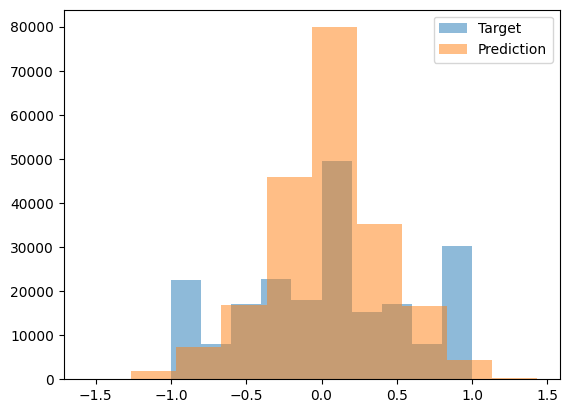

In [16]:
plt.hist(oof1['utility_agent1_true'], alpha=0.5, label='Target')
plt.hist(oof1['utility_agent1_pred'], alpha=0.5, label='Prediction')
plt.legend()
plt.show()

***
### inference

In [17]:
import os
import polars as pl
sys.path.append("../data/raw/")
import kaggle_evaluation.mcts_inference_server

In [18]:
def predict(test: pl.DataFrame, sample_sub: pl.DataFrame):
    # Convert Polars DataFrame to Pandas DataFrame
    test_pd = test.to_pandas()
    
    # Process the test data
    test_processed = process_test_data(
        test_pd,
        numerical_cols,
        categorical_cols,
        encoder,
        scaler
    )

    # Create feature types list for XGBoost
    feature_types = [
        "c" if col in categorical_cols else "q" 
        for col in numerical_cols + categorical_cols
    ]

    # Create XGBoost DMatrix for test data
    test_dmatrix = xgb.DMatrix(
        data=test_processed[numerical_cols + categorical_cols],
        feature_types=feature_types,
        enable_categorical=True
    )

    # Average predictions from all models
    predictions = np.mean([
        model.predict(test_dmatrix)
        for model in trained_models
    ], axis=0)
    predictions = np.clip(predictions, -1, 1)
        
    # Create the submission DataFrame
    submission = sample_sub.with_columns(pl.Series("utility_agent1", predictions))
    
    return submission

In [19]:
inference_server = kaggle_evaluation.mcts_inference_server.MCTSInferenceServer(predict)

if os.getenv('KAGGLE_IS_COMPETITION_RERUN'):
    inference_server.serve()
else:
    inference_server.run_local_gateway(
        (
            '../data/raw/test.csv',
            '../data/raw/sample_submission.csv'
        )
    )

In [20]:
# Save all artifacts needed for prediction
xgboost_predict = {
    'models': trained_models,
    'numerical_cols': numerical_cols,
    'categorical_cols': categorical_cols,
    'encoder': encoder,
    'scaler': scaler
}

with open(f'./xgboost_predict_{fs_type}.pkl', 'wb') as f:
    pickle.dump(xgboost_predict, f)

***